In [69]:
%load_ext autoreload
%autoreload 2

In [392]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [393]:
# параметры распределений
mu0, sigma0 = -2., 1.
mu1, sigma1 = 3., 2.

In [394]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [395]:
d0 = torch.distributions.Normal(torch.tensor([mu0, mu0]), torch.tensor([sigma0, sigma0]))
d1 = torch.distributions.Normal(torch.tensor([mu1, mu1]), torch.tensor([sigma1, sigma1]))

In [396]:
sample(d0, d1)[0][:5], sample(d0, d1)[1][:5]

(tensor([[-3.1928, -1.7435],
         [-2.5912, -1.6732],
         [-0.1525, -1.4072],
         [-0.9229, -2.1960],
         [-2.6255, -1.7630]]), tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]]))

In [397]:
list(map(lambda x: x.shape, sample(d0, d1)))

[torch.Size([64, 2]), torch.Size([64, 1])]

In [398]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.4514, -0.0322]), tensor(0.6397)]


In [399]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            # why number of samples here and below (before backward) is different
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x)) # F.sigmoid (deprecated)
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 1.531709
Ошибка после 1 итераций: 0.328117
Ошибка после 2 итераций: 0.187959
Ошибка после 3 итераций: 0.137107
Ошибка после 4 итераций: 0.111648
Ошибка после 5 итераций: 0.095948
Ошибка после 6 итераций: 0.084781
Ошибка после 7 итераций: 0.076554
Ошибка после 8 итераций: 0.071153
Ошибка после 9 итераций: 0.066707
Ошибка после 10 итераций: 0.063075
Ошибка после 11 итераций: 0.059517
Ошибка после 12 итераций: 0.057383
Ошибка после 13 итераций: 0.055020
Ошибка после 14 итераций: 0.052973
Ошибка после 15 итераций: 0.051940
Ошибка после 16 итераций: 0.049968
Ошибка после 17 итераций: 0.048671
Ошибка после 18 итераций: 0.047645
Ошибка после 19 итераций: 0.046488


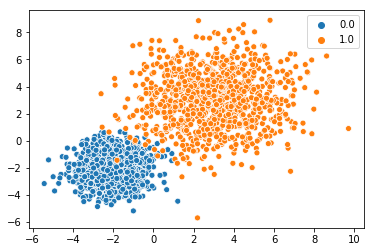

In [400]:
sns.scatterplot(x[:, 0], x[:, 1], hue=y.squeeze());

In [469]:
x_scale = np.linspace(-5, 5, 100)
y_scale = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_scale, y_scale)
XY = np.c_[X.ravel(), Y.ravel()]
X.shape, Y.shape, XY.shape

((100, 100), (100, 100), (10000, 2))

In [470]:
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
pos.shape

(100, 100, 2)

In [471]:
rv1 = stats.multivariate_normal([mu0, mu0], [[sigma0**2, 1], [0, sigma0**2]])
rv2 = stats.multivariate_normal([mu1, mu1], [[sigma1**2, 0], [0, sigma1**2]])
d0_pdf = rv1.pdf(pos)
d1_pdf = rv2.pdf(pos)
ratio = d1_pdf / (d1_pdf + d0_pdf)

In [472]:
XY_tensor = torch.tensor(XY, dtype=torch.float)
with torch.no_grad():
    Z = torch.sigmoid(layer(XY_tensor)).numpy()
Z = Z.reshape(X.shape)
Z

array([[2.8782171e-05, 3.1867916e-05, 3.5284404e-05, ..., 3.5968783e-01,
        3.8346326e-01, 4.0780947e-01],
       [3.2307573e-05, 3.5771231e-05, 3.9606206e-05, ..., 3.8670811e-01,
        4.1112283e-01, 4.3598333e-01],
       [3.6264701e-05, 4.0152619e-05, 4.4457258e-05, ..., 4.1444421e-01,
        4.3935558e-01, 4.6457645e-01],
       ...,
       [6.7971218e-01, 7.0146739e-01, 7.2234839e-01, ..., 9.9997580e-01,
        9.9997818e-01, 9.9998033e-01],
       [7.0432878e-01, 7.2508818e-01, 7.4491787e-01, ..., 9.9997854e-01,
        9.9998057e-01, 9.9998248e-01],
       [7.2781122e-01, 7.4751294e-01, 7.6624656e-01, ..., 9.9998081e-01,
        9.9998271e-01, 9.9998438e-01]], dtype=float32)

No handles with labels found to put in legend.


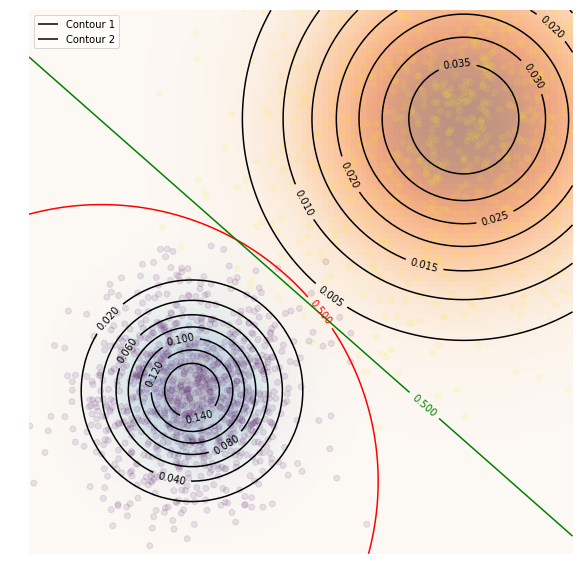

In [496]:
fig, axes = plt.subplots(figsize=(10, 10))

contour_d0 = plt.contour(X, Y, d0_pdf, colors='black')
plt.clabel(contour_d0, colors='black')
plt.imshow(d0_pdf, extent = [-5, 5, -5, 5], cmap='Blues', origin='lower', alpha=0.5)

contour_d1 = plt.contour(X, Y, d1_pdf, colors='black')
plt.clabel(contour_d1, colors='black')
plt.imshow(d1_pdf, extent = [-5, 5, -5, 5], cmap='Oranges', origin='lower', alpha=0.5)

contour_ratio = plt.contour(X, Y, ratio, levels=[0, 0.5, 1], colors='red')
plt.clabel(contour_ratio, colors='red')
#plt.imshow(d1_pdf, extent = [-5, 5, -5, 5], cmap='Reds', origin='lower', alpha=0.5)

contour_Z = plt.contour(X, Y, Z, levels=[0, 0.5, 1], colors='green')
plt.clabel(contour_Z, colors='green')
#plt.imshow(d1_pdf, extent = [-5, 5, -5, 5], cmap='W', origin='lower', alpha=0.5)

# plt.contour(X, Y, ratio, levels=[0, 0.5, 1], colors='red')
# plt.contour(X, Y, Z, levels=[0.5], colors='green')

plt.axis('off')

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], alpha=0.1, c=y.squeeze())
plt.xlim(-5, 5)
plt.ylim(-5, 5)


h1, _ = contour_d0.legend_elements()
h2, _ = contour_d1.legend_elements()
plt.legend([h1[0], h2[0]], ['Contour 1', 'Contour 2'])

In [474]:
XY_tensor = torch.tensor(XY, dtype=torch.float)

with torch.no_grad():
    dist = torch.sigmoid(layer(XY_tensor)).numpy()
dist

array([[2.8782171e-05],
       [3.1867916e-05],
       [3.5284404e-05],
       ...,
       [9.9998081e-01],
       [9.9998271e-01],
       [9.9998438e-01]], dtype=float32)

In [475]:
torch.sigmoid(layer(torch.tensor(x_scale, dtype=torch.float)))

RuntimeError: size mismatch, m1: [1 x 100], m2: [2 x 1] at /opt/conda/conda-bld/pytorch_1532579245307/work/aten/src/TH/generic/THTensorMath.cpp:2070

In [280]:
x_scale = np.linspace(-10, 10, 5000)
d0_pdf = stats.norm.pdf(x_scale, mu0, sigma0) 
d1_pdf = stats.norm.pdf(x_scale, mu1, sigma1)
x_tensor = torch.tensor(x_scale.reshape(-1, 1), dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(x_tensor)).numpy()
ratio = d1_pdf / (d1_pdf + d0_pdf)

RuntimeError: size mismatch, m1: [5000 x 1], m2: [2 x 1] at /opt/conda/conda-bld/pytorch_1532579245307/work/aten/src/TH/generic/THTensorMath.cpp:2070

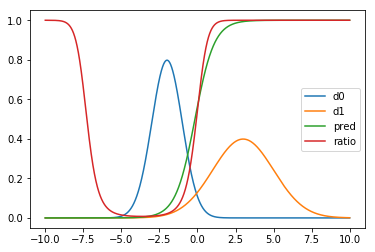

In [11]:
plt.plot(x_scale, d0_pdf*2, label='d0') # умножение на 2 для красоты графиков, на распределения не влияет
plt.plot(x_scale, d1_pdf*2, label='d1')
plt.plot(x_scale, dist.flatten(), label='pred')
plt.plot(x_scale, ratio, label='ratio')
plt.legend();

In [12]:
print([p.data[0] for p in layer.parameters()])

[tensor([1.5780]), tensor(0.2613)]


In [14]:
torch.log(torch.sigmoid(torch.tensor(-100.)))

tensor(-inf)

In [15]:
F.logsigmoid(torch.tensor(-100.))

tensor(-100.)